In [1]:
!pip install install transformers==4.35 openai llama_hub llama_index pypdf accelerate sentence_transformers einops -q -U
!pip install bitsandbytes
!pip install accelerate
!pip install -i https://test.pypi.org/simple/ bitsandbytes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.4/225.4 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.9/75.9 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.0/143.0 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 28.1 MB/s e

In [2]:
from llama_index.node_parser import SimpleNodeParser
from llama_index.text_splitter import SentenceSplitter
from llama_index.node_parser import SentenceWindowNodeParser
from llama_index import VectorStoreIndex, SimpleDirectoryReader
from llama_index.schema import IndexNode
from llama_index import VectorStoreIndex, ServiceContext
from llama_index.llms import HuggingFaceLLM
from llama_index.prompts import PromptTemplate
from transformers import BitsAndBytesConfig
from llama_index.query_engine import RetrieverQueryEngine
from llama_index.retrievers import RecursiveRetriever
from llama_index.response.notebook_utils import display_response
from llama_index.response.notebook_utils import display_source_node
from llama_index.embeddings import resolve_embed_model
from llama_index.embeddings import HuggingFaceEmbedding
from llama_index.evaluation import generate_question_context_pairs
from llama_index.evaluation import RetrieverEvaluator
from llama_index.evaluation import FaithfulnessEvaluator
from llama_index.evaluation import RelevancyEvaluator
from llama_index.evaluation import BatchEvalRunner
import nest_asyncio
import pandas as pd
import torch

from typing import List
import re

In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
import transformers
import openai
import llama_hub
import llama_index
import pypdf
import accelerate
import sentence_transformers
import pydantic
import bitsandbytes
import accelerate

print("transformers:", transformers.__version__)
print("openai:", openai.__version__)
#print("llama_hub:", llama_hub.__version__)
print("llama_index:", llama_index.__version__)
print("pypdf:", pypdf.__version__)
print("accelerate:", accelerate.__version__)
print("sentence_transformers:", sentence_transformers.__version__)
print("pydantic:", pydantic.__version__)
#print("bitsandbytes:", bitsandbytes.__version__)
print("accelerate:", accelerate.__version__)

transformers: 4.35.0
openai: 1.6.1
llama_index: 0.9.22
pypdf: 3.17.4
accelerate: 0.25.0
sentence_transformers: 2.2.2
pydantic: 1.10.13
accelerate: 0.25.0


In [4]:
!mkdir data
!curl 'https://raw.githubusercontent.com/run-llama/llama_index/main/docs/examples/data/paul_graham/paul_graham_essay.txt' -o 'data/paul_graham_essay.txt'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 75042  100 75042    0     0   186k      0 --:--:-- --:--:-- --:--:--  187k


In [5]:
#from llama_hub.file.pdf.base import PDFReader
#from pathlib import Path

#loader = PDFReader()
#docs0 = loader.load_data(file=Path("/content/State of AI Report 2023 - ONLINE.pdf"))

In [6]:
docs0 = SimpleDirectoryReader("./data/").load_data()

In [ ]:
docs0[0]

Document(id_='4ec4ad8e-8cef-4ea4-92cc-14164c5969d8', embedding=None, metadata={'file_path': 'data/paul_graham_essay.txt', 'file_name': 'paul_graham_essay.txt', 'file_type': 'text/plain', 'file_size': 75042, 'creation_date': '2023-12-29', 'last_modified_date': '2023-12-29', 'last_accessed_date': '2023-12-29'}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], excluded_llm_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], relationships={}, hash='33bd0157bfdc0ac782fabdbe022a3b33cc7fc1d798a620105556b9d6ac7bd1d7', text='\n\nWhat I Worked On\n\nFebruary 2021\n\nBefore college the two main things I worked on, outside of school, were writing and programming. I didn\'t write essays. I wrote what beginning writers were supposed to write then, and probably still are: short stories. My stories were awful. They had hardly any plot, just characters with s

In [ ]:
print(f" docs is a {type(docs0)}, of length {len(docs0)}, where each element is a {type(docs0[0])} object")

 docs is a <class 'list'>, of length 1, where each element is a <class 'llama_index.schema.Document'> object


In [ ]:
docs0[0].get_content()


'\n\nWhat I Worked On\n\nFebruary 2021\n\nBefore college the two main things I worked on, outside of school, were writing and programming. I didn\'t write essays. I wrote what beginning writers were supposed to write then, and probably still are: short stories. My stories were awful. They had hardly any plot, just characters with strong feelings, which I imagined made them deep.\n\nThe first programs I tried writing were on the IBM 1401 that our school district used for what was then called "data processing." This was in 9th grade, so I was 13 or 14. The school district\'s 1401 happened to be in the basement of our junior high school, and my friend Rich Draves and I got permission to use it. It was like a mini Bond villain\'s lair down there, with all these alien-looking machines — CPU, disk drives, printer, card reader — sitting up on a raised floor under bright fluorescent lights.\n\nThe language we used was an early version of Fortran. You had to type programs on punch cards, then s

In [ ]:
#Not needed now, only if you need cleaning of text to avoid unnecessary embedding for noise data

def clean_slide_text(text: str) -> str:
    """
    Cleans the provided slide text by removing specific patterns and extra whitespace.

    Parameters:
    - text (str): The raw text from a slide.

    Returns:
    - str: The cleaned text.

    Example:
    >>> clean_slide_text("LINGO-1 is Wayve’s vision-language-action model ... stateof.ai 2023 #stateofai | 43 \nLeveraging LLMs for autonomous driving'")
    'LINGO-1 is Wayve’s vision-language-action model ... Leveraging LLMs for autonomous driving'
    """
    # Remove the footer text
    text = text.replace("stateof.ai 2023", "")

    # Remove the header text
    text = text.replace("Introduction  | Research  | Industry  | Politics  | Safety  | Predictions", "")

    # Remove the pattern "#stateofai | n"
    text = re.sub(r"#stateofai(\s*\|\s*\d+)?", "", text)

    # Replace multiple consecutive spaces with a single space
    text = re.sub(r" +", " ", text)

    # Remove any leading or trailing whitespace
    text = text.strip()

    return text

#Not needed now, used if you want to add additional meta data to each of the document objects.
def assign_section(document):
    """
    Assigns a section to the document based on its page number.

    The function updates the 'metadata' attribute of the document with a key 'section'
    that has a value corresponding to the section the page number falls into.

    Sections:
    - Page 1 through 10: Introduction
    - Page 11 through 68: Research
    - Page 69 through 120: Politics
    - Page 121 through 137: Safety
    - Pages 138 and beyond: Predictions

    Args:
    - document (Document): The Document object to be updated.

    Returns:
    None. The function updates the Document object in-place.
    """

    page_number = int(document.metadata['page_label'])

    if 1 <= page_number <= 10:
        document.metadata['section'] = 'Introduction'
    elif 11 <= page_number <= 68:
        document.metadata['section'] = 'Research'
    elif 69 <= page_number <= 120:
        document.metadata['section'] = 'Politics'
    elif 121 <= page_number <= 137:
        document.metadata['section'] = 'Safety'
    else:
        document.metadata['section'] = 'Predictions'

# Iterate through each Document object in docs0
#for doc in docs0:
#    # Update the metadata using assign_section
#    assign_section(doc)

    # Metadata keys that are excluded from text for the embed model.
#    doc.excluded_embed_metadata_keys=['file_name']

    # Apply clean_slide_text to the text attribute
#    doc.text = clean_slide_text(doc.text)

In [ ]:
#docs0[94].metadata
#docs0[94].text
#docs0[94].get_content()

In [ ]:
#EDA of Document. Just extra info & prints. Can be skipped

# Define the pattern for bullet points and newlines
split_pattern = r"\n●|\n-|\n"

# Initialize lists to store the word counts of all chunks and entire texts across all documents
chunk_word_counts = []
entire_text_word_counts = []

# Initialize a dictionary to store word counts and slide counts by section
section_data = {}

# Iterate through each Document object in your list of documents
for doc in docs0:
    # Split the document's text into chunks based on the pattern
    chunks = re.split(split_pattern, doc.text)

    # Calculate the number of words in each chunk and store it
    chunk_word_counts.extend([len(chunk.split()) for chunk in chunks])

    # Calculate the number of words in the entire text and store it
    entire_word_count = len(doc.text.split())
    entire_text_word_counts.append(entire_word_count)

    # Update the word count and slide count for the section in the dictionary
    section = doc.metadata['section']
    if section in section_data:
        section_data[section]['word_count'] += entire_word_count
        section_data[section]['slide_count'] += 1
    else:
        section_data[section] = {'word_count': entire_word_count,
                                 'slide_count': 1}

# Calculate the total word count across all sections
total_word_count = sum(data['word_count'] for data in section_data.values())

# Calculate the number of sections
num_sections = len(section_data)

# Calculate the average word count across all sections
average_word_count_across_sections = total_word_count / num_sections

# Calculate summary statistics for chunks
average_chunk_word_count = sum(chunk_word_counts) / len(chunk_word_counts)
max_chunk_word_count = max(chunk_word_counts)

# Calculate average word count for entire texts
average_entire_text_word_count = sum(entire_text_word_counts) / len(entire_text_word_counts)

print(f"Average word count for a slide: {average_entire_text_word_count}")
print(f"Average word count per bullet point: {average_chunk_word_count}")
print(f"Longest bullet point: {max_chunk_word_count}")
print(f"Average word count in a section: {average_word_count_across_sections:.2f}")

KeyError: ignored

In [7]:
#splitter = r'\n●|\n-|\n'
splitter = r'\n'

bullet_splitter = SentenceSplitter(paragraph_separator=splitter,
                                   chunk_overlap = 200,
                                   chunk_size=1000)

#slides_parser = SimpleNodeParser.from_defaults(
#    text_splitter=bullet_splitter,
#    include_prev_next_rel=True,
#    include_metadata=True
#    )

slides_nodes = bullet_splitter.get_nodes_from_documents(
    docs0, include_prev_next_rel=True,include_metadata=True,show_progress=False
)

def custom_sentence_splitter(text: str) -> List[str]:
    return re.split(splitter, text)

bullet_node_parser = SentenceWindowNodeParser.from_defaults(
    sentence_splitter=custom_sentence_splitter,
    window_size=3,
    include_prev_next_rel=True,
    include_metadata=True
    )

sub_node_parsers =[]
all_nodes = []

for base_node in slides_nodes:
    sub_nodes = bullet_node_parser.get_nodes_from_documents([base_node])
    sub_inodes = [
        IndexNode.from_text_node(sn, base_node.node_id) for sn in sub_nodes
    ]
    all_nodes.extend(sub_inodes)

    # also add original node to node
    original_node = IndexNode.from_text_node(base_node, base_node.node_id)
    all_nodes.append(original_node)

all_nodes_dict = {n.node_id: n for n in all_nodes}

In [ ]:
len(all_nodes)

466

In [ ]:
len(slides_nodes)

22

In [ ]:
slides_nodes[0].text

'What I Worked On\n\nFebruary 2021\n\nBefore college the two main things I worked on, outside of school, were writing and programming. I didn\'t write essays. I wrote what beginning writers were supposed to write then, and probably still are: short stories. My stories were awful. They had hardly any plot, just characters with strong feelings, which I imagined made them deep.\n\nThe first programs I tried writing were on the IBM 1401 that our school district used for what was then called "data processing." This was in 9th grade, so I was 13 or 14. The school district\'s 1401 happened to be in the basement of our junior high school, and my friend Rich Draves and I got permission to use it. It was like a mini Bond villain\'s lair down there, with all these alien-looking machines — CPU, disk drives, printer, card reader — sitting up on a raised floor under bright fluorescent lights.\n\nThe language we used was an early version of Fortran. You had to type programs on punch cards, then stack

In [ ]:
slides_nodes[1].text

'All that seemed left for philosophy were edge cases that people in other fields felt could safely be ignored.\n\nI couldn\'t have put this into words when I was 18. All I knew at the time was that I kept taking philosophy courses and they kept being boring. So I decided to switch to AI.\n\nAI was in the air in the mid 1980s, but there were two things especially that made me want to work on it: a novel by Heinlein called The Moon is a Harsh Mistress, which featured an intelligent computer called Mike, and a PBS documentary that showed Terry Winograd using SHRDLU. I haven\'t tried rereading The Moon is a Harsh Mistress, so I don\'t know how well it has aged, but when I read it I was drawn entirely into its world. It seemed only a matter of time before we\'d have Mike, and when I saw Winograd using SHRDLU, it seemed like that time would be a few years at most. All you had to do was teach SHRDLU more words.\n\nThere weren\'t any classes in AI at Cornell then, not even graduate classes, so

In [ ]:
all_nodes[0].text
all_nodes[0]

'What I Worked On'

IndexNode(id_='53a37b9a-1eaa-4dd5-ad36-cb813ebadadc', embedding=None, metadata={'window': 'What I Worked On  February 2021', 'original_text': 'What I Worked On', 'file_path': 'data/paul_graham_essay.txt', 'file_name': 'paul_graham_essay.txt', 'file_type': 'text/plain', 'file_size': 75042, 'creation_date': '2023-12-29', 'last_modified_date': '2023-12-29', 'last_accessed_date': '2023-12-29'}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date', 'window', 'original_text'], excluded_llm_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date', 'window', 'original_text'], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='0dea44fe-7f21-49b6-8a0c-4b02b4c79737', node_type=<ObjectType.TEXT: '1'>, metadata={'file_path': 'data/paul_graham_essay.txt', 'file_name': 'paul_graham_essay.txt', 'file_type': 'text/plain', 'file_size': 75042, 'creation

In [ ]:
all_nodes[1].text
all_nodes[1]

''

IndexNode(id_='babdec34-c5e3-4f36-9206-b6e40b49d62a', embedding=None, metadata={'window': 'What I Worked On  February 2021 ', 'original_text': '', 'file_path': 'data/paul_graham_essay.txt', 'file_name': 'paul_graham_essay.txt', 'file_type': 'text/plain', 'file_size': 75042, 'creation_date': '2023-12-29', 'last_modified_date': '2023-12-29', 'last_accessed_date': '2023-12-29'}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date', 'window', 'original_text'], excluded_llm_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date', 'window', 'original_text'], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='0dea44fe-7f21-49b6-8a0c-4b02b4c79737', node_type=<ObjectType.TEXT: '1'>, metadata={'file_path': 'data/paul_graham_essay.txt', 'file_name': 'paul_graham_essay.txt', 'file_type': 'text/plain', 'file_size': 75042, 'creation_date': '2023-1

In [ ]:
all_nodes[2].text
all_nodes[2]

'February 2021'

IndexNode(id_='aae138a1-5376-42dd-837f-715d83931d40', embedding=None, metadata={'window': "What I Worked On  February 2021  Before college the two main things I worked on, outside of school, were writing and programming. I didn't write essays. I wrote what beginning writers were supposed to write then, and probably still are: short stories. My stories were awful. They had hardly any plot, just characters with strong feelings, which I imagined made them deep.", 'original_text': 'February 2021', 'file_path': 'data/paul_graham_essay.txt', 'file_name': 'paul_graham_essay.txt', 'file_type': 'text/plain', 'file_size': 75042, 'creation_date': '2023-12-29', 'last_modified_date': '2023-12-29', 'last_accessed_date': '2023-12-29'}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date', 'window', 'original_text'], excluded_llm_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last

In [ ]:
all_nodes[3].text
all_nodes[3]

''

IndexNode(id_='118fb54b-c325-4f04-8a7d-4cf4721855af', embedding=None, metadata={'window': "What I Worked On  February 2021  Before college the two main things I worked on, outside of school, were writing and programming. I didn't write essays. I wrote what beginning writers were supposed to write then, and probably still are: short stories. My stories were awful. They had hardly any plot, just characters with strong feelings, which I imagined made them deep. ", 'original_text': '', 'file_path': 'data/paul_graham_essay.txt', 'file_name': 'paul_graham_essay.txt', 'file_type': 'text/plain', 'file_size': 75042, 'creation_date': '2023-12-29', 'last_modified_date': '2023-12-29', 'last_accessed_date': '2023-12-29'}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date', 'window', 'original_text'], excluded_llm_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_da

In [ ]:
all_nodes[4].text
all_nodes[4]

"Before college the two main things I worked on, outside of school, were writing and programming. I didn't write essays. I wrote what beginning writers were supposed to write then, and probably still are: short stories. My stories were awful. They had hardly any plot, just characters with strong feelings, which I imagined made them deep."

IndexNode(id_='c5e96ffc-5ae0-43cd-9f1a-64280231e09d', embedding=None, metadata={'window': ' February 2021  Before college the two main things I worked on, outside of school, were writing and programming. I didn\'t write essays. I wrote what beginning writers were supposed to write then, and probably still are: short stories. My stories were awful. They had hardly any plot, just characters with strong feelings, which I imagined made them deep.  The first programs I tried writing were on the IBM 1401 that our school district used for what was then called "data processing." This was in 9th grade, so I was 13 or 14. The school district\'s 1401 happened to be in the basement of our junior high school, and my friend Rich Draves and I got permission to use it. It was like a mini Bond villain\'s lair down there, with all these alien-looking machines — CPU, disk drives, printer, card reader — sitting up on a raised floor under bright fluorescent lights.', 'original_text': "Before college the tw

In [ ]:
all_nodes[5].text
all_nodes[5]

''

IndexNode(id_='707f0355-d2a1-4bfe-8709-a011d0c817f8', embedding=None, metadata={'window': 'February 2021  Before college the two main things I worked on, outside of school, were writing and programming. I didn\'t write essays. I wrote what beginning writers were supposed to write then, and probably still are: short stories. My stories were awful. They had hardly any plot, just characters with strong feelings, which I imagined made them deep.  The first programs I tried writing were on the IBM 1401 that our school district used for what was then called "data processing." This was in 9th grade, so I was 13 or 14. The school district\'s 1401 happened to be in the basement of our junior high school, and my friend Rich Draves and I got permission to use it. It was like a mini Bond villain\'s lair down there, with all these alien-looking machines — CPU, disk drives, printer, card reader — sitting up on a raised floor under bright fluorescent lights. ', 'original_text': '', 'file_path': 'data

In [ ]:
all_nodes[6].text
all_nodes[6]

'The first programs I tried writing were on the IBM 1401 that our school district used for what was then called "data processing." This was in 9th grade, so I was 13 or 14. The school district\'s 1401 happened to be in the basement of our junior high school, and my friend Rich Draves and I got permission to use it. It was like a mini Bond villain\'s lair down there, with all these alien-looking machines — CPU, disk drives, printer, card reader — sitting up on a raised floor under bright fluorescent lights.'

IndexNode(id_='bb7671ea-4dc2-4ec9-ba68-9d21ba93f59e', embedding=None, metadata={'window': ' Before college the two main things I worked on, outside of school, were writing and programming. I didn\'t write essays. I wrote what beginning writers were supposed to write then, and probably still are: short stories. My stories were awful. They had hardly any plot, just characters with strong feelings, which I imagined made them deep.  The first programs I tried writing were on the IBM 1401 that our school district used for what was then called "data processing." This was in 9th grade, so I was 13 or 14. The school district\'s 1401 happened to be in the basement of our junior high school, and my friend Rich Draves and I got permission to use it. It was like a mini Bond villain\'s lair down there, with all these alien-looking machines — CPU, disk drives, printer, card reader — sitting up on a raised floor under bright fluorescent lights.  The language we used was an early version of Fortran. Y

In [ ]:
len(all_nodes)
len(slides_nodes)

466

22

In [8]:
#from llama_index.embeddings import InstructorEmbedding
#from langchain.embeddings.huggingface import HuggingFaceEmbeddings
#from llama_index import LangchainEmbedding, ServiceContext

embed_model = resolve_embed_model("local:BAAI/bge-small-en-v1.5")
#embed_model = HuggingFaceEmbedding(model_name="mistralai/Mixtral-8x7B-Instruct-v0.1")
#embed_model = resolve_embed_model('local:nlpaueb/legal-bert-small-uncased')

#embed_model = LangchainEmbedding(
#  HuggingFaceEmbeddings(model_name="thenlper/gte-large")
#)


In [ ]:
template = """Below is context that has been retrieved. Your task is to synthesize \

the query, which is delimited by triple backticks,  and write a response that appropriately answers the query based on the retrieved context.

### Query:
```{query_str}```

### Response:

Begin!
"""

template ="""
### System:
Below is context that has been retrieved. Your task is to synthesize \

the query, which is delimited by triple backticks,  and write a response that appropriately answers the query based on the retrieved context.
### User:
```
{query_str}
```
### Assistant:
"""

template='Instruct: {query_str} \n Output:'

In [9]:
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
)
    #model_name="Deci/DeciLM-6b-instruct",
    #tokenizer_name="Deci/DeciLM-6b-instruct",
    #model_name="microsoft/phi-2",
    #tokenizer_name="microsoft/phi-2",

llm = HuggingFaceLLM(
    model_name="mistralai/Mistral-7B-Instruct-v0.1",
    tokenizer_name="mistralai/Mistral-7B-Instruct-v0.1",
    #query_wrapper_prompt=PromptTemplate("<s>[INST] {query_str} [/INST] </s>\n"),
    #model_name="google/flan-t5-small",
    #tokenizer='google/flan-t5-small',
    #query_wrapper_prompt=PromptTemplate("<|system|>\n</s>\n<|user|>\n{query_str}</s>\n<|assistant|>\n"),
    #query_wrapper_prompt=PromptTemplate(template),
    context_window=3900,
    max_new_tokens=256,
    model_kwargs={'trust_remote_code':True, "quantization_config": quantization_config},
    generate_kwargs={"temperature": 0.02, "top_k": 5, "top_p": 0.95,"do_sample":True },
    device_map="auto",)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [10]:
service_context = ServiceContext.from_defaults(llm=llm,
                                               embed_model=embed_model)
vector_index_chunk = VectorStoreIndex(all_nodes,
                                      service_context=service_context)
vector_retriever_chunk = vector_index_chunk.as_retriever(similarity_top_k=2)

retriever_chunk = RecursiveRetriever(
                                    "vector",
                                    retriever_dict={"vector": vector_retriever_chunk},
                                    node_dict=all_nodes_dict,
                                    verbose=True)


nodes = retriever_chunk.retrieve("What did the author do growing up?")

for node in nodes:
    display_source_node(node, source_length=1000)

query_engine_chunk = RetrieverQueryEngine.from_args(
    retriever_chunk,
    service_context=service_context,
    verbose=True,
    response_mode="compact",
)

Retrieving with query id None: What did the author do growing up?
Retrieved node with id, entering: 55d6d88a-251f-4e49-932e-a84411494dbe
Retrieving with query id 55d6d88a-251f-4e49-932e-a84411494dbe: What did the author do growing up?
Retrieved node with id, entering: 87716e5a-ec9c-4afa-bd4a-ce9dd8c5f85b
Retrieving with query id 87716e5a-ec9c-4afa-bd4a-ce9dd8c5f85b: What did the author do growing up?


**Node ID:** 55d6d88a-251f-4e49-932e-a84411494dbe<br>**Similarity:** 0.6180608944451951<br>**Text:** What I Worked On

February 2021

Before college the two main things I worked on, outside of school, were writing and programming. I didn't write essays. I wrote what beginning writers were supposed to write then, and probably still are: short stories. My stories were awful. They had hardly any plot, just characters with strong feelings, which I imagined made them deep.

The first programs I tried writing were on the IBM 1401 that our school district used for what was then called "data processing." This was in 9th grade, so I was 13 or 14. The school district's 1401 happened to be in the basement of our junior high school, and my friend Rich Draves and I got permission to use it. It was like a mini Bond villain's lair down there, with all these alien-looking machines — CPU, disk drives, printer, card reader — sitting up on a raised floor under bright fluorescent lights.

The language we used was an early version of Fortran. You had to type programs on punch cards, then stack them in ...<br>

**Node ID:** 87716e5a-ec9c-4afa-bd4a-ce9dd8c5f85b<br>**Similarity:** 0.5948471786934123<br>**Text:** I knew that online essays would be a marginal medium at first. Socially they'd seem more like rants posted by nutjobs on their GeoCities sites than the genteel and beautifully typeset compositions published in The New Yorker. But by this point I knew enough to find that encouraging instead of discouraging.

One of the most conspicuous patterns I've noticed in my life is how well it has worked, for me at least, to work on things that weren't prestigious. Still life has always been the least prestigious form of painting. Viaweb and Y Combinator both seemed lame when we started them. I still get the glassy eye from strangers when they ask what I'm writing, and I explain that it's an essay I'm going to publish on my web site. Even Lisp, though prestigious intellectually in something like the way Latin is, also seems about as hip.

It's not that unprestigious types of work are good per se. But when you find yourself drawn to some kind of work despite its current lack of prestige, it's a ...<br>

In [ ]:
response = query_engine_chunk.query(
  "What did the author do growing up?"
)
display_response(response)

Retrieving with query id None: What did the author do growing up?
Retrieved node with id, entering: fb004be6-fd01-4941-b203-459c0a94a30b
Retrieving with query id fb004be6-fd01-4941-b203-459c0a94a30b: What did the author do growing up?
Retrieved node with id, entering: 2fb64a73-5396-4913-8c3e-79711390a9f0
Retrieving with query id 2fb64a73-5396-4913-8c3e-79711390a9f0: What did the author do growing up?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


**`Final Response:`** The author grew up working on writing and programming. He didn't write essays, he wrote short stories. The first programs he tried writing were on the IBM 1401, an early version of Fortran. He was puzzled by the 1401 and couldn't figure out what to do with it. With microcomputers, everything changed. He started programming and wrote simple games, a program to predict how high his model rockets would fly, and a word processor that his father used to write at least one book.

In [37]:
vector_index = VectorStoreIndex.from_documents(docs0, service_context=service_context)
query_engine = vector_index.as_query_engine(response_mode="compact")
response = query_engine.query("What did the author do growing up?")
display_response(response)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


**`Final Response:`** Before college, the two main things the author worked on, outside of school, were writing and programming. He didn't write essays. He wrote what beginning writers were supposed to write then, and probably still are: short stories. His stories were awful. They had hardly any plot, just characters with strong feelings, which he imagined made them deep.

The first programs he tried writing were on the IBM 1401 that his school district used for data processing. This was in 9th grade, so he was 13 or 14. The language he used was an early version of Fortran. You had to type programs on punch cards, then stack them in the card reader and press a button to load the program into memory and run it.

He was puzzled by the 1401. He couldn't figure out what to do with it. And in retrospect, there's not much he could have done with it. The only form of input to programs was data stored on punched cards, and he didn't have any data stored on punched cards. The only other option was to do things that didn't rely on any input, like calculate approximations of pi

In [16]:
#vector_index = VectorStoreIndex(all_nodes,service_context=service_context)
#query_engine = vector_index.as_query_engine()

qa_dataset = generate_question_context_pairs(
    all_nodes,
    llm=llm,
    num_questions_per_chunk=2
)

100%|██████████| 466/466 [27:38<00:00,  3.56s/it]


In [38]:
qa_dataset

EmbeddingQAFinetuneDataset(queries={'e35fe248-1720-4047-8f8d-11630312757a': '---------------------', '8e91fc98-5937-4394-aa73-b6011fec5558': 'Context Information', '12731bed-100c-43ee-96ce-9734ea59c1d0': '---------------------', '42cff5cf-ff36-4731-9169-d3a0face5bb1': 'What is the capital of France?', 'cf231991-cc9a-41b9-b007-884042969fe7': 'What is the population of the United States?', 'fd502bcf-c803-4804-a0d7-cb26a83225c4': 'What is the highest mountain in the world?', 'c5ff07d3-6de4-45b1-8f7c-7710598cb919': 'What is the largest planet in our solar system?', '9664a351-57f8-49b8-87d9-9c7b6eae60f1': 'What is the smallest country in the world?', '311994f6-8249-4cf3-8b0a-8719dca9f4c4': 'What is the largest animal on earth?', 'f7f9465d-eaba-4f87-8af9-098878d9f867': 'What is the smallest mammal on earth?', 'd940c2ca-43c7-4cb2-aa11-57842b6ce3fe': 'What is the largest mammal on earth?', 'af42c994-a004-45c7-916f-cbc33eed8b25': 'What is the smallest bird on earth?', '4e7bef33-cc22-408a-aac8-d

In [17]:
def display_results(name, eval_results):
    """Display results from evaluate."""

    metric_dicts = []
    for eval_result in eval_results:
        metric_dict = eval_result.metric_vals_dict
        metric_dicts.append(metric_dict)
        #print(metric_dicts)

    full_df = pd.DataFrame(metric_dicts)

    hit_rate = full_df["hit_rate"].mean()
    mrr = full_df["mrr"].mean()

    metric_df = pd.DataFrame(
        {"Retriever Name": [name], "Hit Rate": [hit_rate], "MRR": [mrr]}
    )

    return metric_df

In [18]:
#vector_index = VectorStoreIndex(all_nodes,service_context=service_context)

#retriever = vector_index.as_retriever(similarity_top_k=2)

retriever_evaluator = RetrieverEvaluator.from_metric_names(
    ["mrr", "hit_rate"], retriever=vector_retriever_chunk
)

eval_results = await retriever_evaluator.aevaluate_dataset(qa_dataset)

display_results("Custom Chunked Embedding Retriever", eval_results)


,Retriever Name,Hit Rate,MRR
0,Custom Chunked Embedding Retriever,0.253912,0.226885


In [19]:
vector_index = VectorStoreIndex(all_nodes,service_context=service_context)

retriever = vector_index.as_retriever(similarity_top_k=2)

retriever_evaluator = RetrieverEvaluator.from_metric_names(
    ["mrr", "hit_rate"], retriever=retriever
)

eval_results = await retriever_evaluator.aevaluate_dataset(qa_dataset)

display_results("Custom OneDOC Embedding Retriever", eval_results)

,Retriever Name,Hit Rate,MRR
0,Custom OneDOC Embedding Retriever,0.253912,0.226885


In [20]:
display_results("Custom OneDOC Embedding Retriever", eval_results).to_markdown()

'|    | Retriever Name                    |   Hit Rate |      MRR |\n|---:|:----------------------------------|-----------:|---------:|\n|  0 | Custom OneDOC Embedding Retriever |   0.253912 | 0.226885 |'

In [26]:
# Get the list of queries from the above created dataset
queries = list(qa_dataset.queries.values())

In [35]:
queries[4:14]

['What is the population of the United States?',
 'What is the highest mountain in the world?',
 'What is the largest planet in our solar system?',
 'What is the smallest country in the world?',
 'What is the largest animal on earth?',
 'What is the smallest mammal on earth?',
 'What is the largest mammal on earth?',
 'What is the smallest bird on earth?',
 'What is the largest bird on earth?',
 'What is the smallest fish on earth?']

In [55]:
faithfulness = FaithfulnessEvaluator(service_context=service_context)

eval_query = queries[30]
eval_query

response_vector = query_engine_chunk.query(eval_query)

# Compute faithfulness evaluation

nest_asyncio.apply()

eval_result = faithfulness.evaluate_response(response=response_vector)

# You can check passing parameter in eval_result if it passed the evaluation.
eval_result.passing

response_vector = query_engine.query(eval_query)

# Compute faithfulness evaluation
nest_asyncio.apply()

eval_result = faithfulness.evaluate_response(response=response_vector)

# You can check passing parameter in eval_result if it passed the evaluation.
eval_result.passing

'What is the name of the person who wrote the book "The Great Gatsby"?'

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Retrieving with query id None: What is the name of the person who wrote the book "The Great Gatsby"?
Retrieved node with id, entering: ed09195e-954b-414f-89a0-c78886a6b6c1
Retrieving with query id ed09195e-954b-414f-89a0-c78886a6b6c1: What is the name of the person who wrote the book "The Great Gatsby"?
Retrieved node with id, entering: 87716e5a-ec9c-4afa-bd4a-ce9dd8c5f85b
Retrieving with query id 87716e5a-ec9c-4afa-bd4a-ce9dd8c5f85b: What is the name of the person who wrote the book "The Great Gatsby"?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


True

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


False

In [54]:
relevancy = RelevancyEvaluator(service_context=service_context)
# Pick a query
query = queries[30]
query

# Generate response.
# response_vector has response and source nodes (retrieved context)
response_vector = query_engine_chunk.query(query)

nest_asyncio.apply()

# Relevancy evaluation
eval_result =  relevancy.evaluate_response(
    query=query, response=response_vector
)

# You can check passing parameter in eval_result if it passed the evaluation.
eval_result.passing

# You can get the feedback for the evaluation.
eval_result.feedback

response_vector = query_engine.query(query)

nest_asyncio.apply()

# Relevancy evaluation
eval_result =  relevancy.evaluate_response(
    query=query, response=response_vector
)

# You can check passing parameter in eval_result if it passed the evaluation.
eval_result.passing

# You can get the feedback for the evaluation.
eval_result.feedback

'What is the name of the person who wrote the book "The Great Gatsby"?'

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Retrieving with query id None: What is the name of the person who wrote the book "The Great Gatsby"?
Retrieved node with id, entering: ed09195e-954b-414f-89a0-c78886a6b6c1
Retrieving with query id ed09195e-954b-414f-89a0-c78886a6b6c1: What is the name of the person who wrote the book "The Great Gatsby"?
Retrieved node with id, entering: 87716e5a-ec9c-4afa-bd4a-ce9dd8c5f85b
Retrieving with query id 87716e5a-ec9c-4afa-bd4a-ce9dd8c5f85b: What is the name of the person who wrote the book "The Great Gatsby"?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


True

'\nYES, the response for the query "What is the name of the person who wrote the book "The Great Gatsby" is F. Scott Fitzgerald" is in line with the context information provided.'

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


True

'\n\nYES, the response for the query "What is the name of the person who wrote the book "The Great Gatsby"?" is in line with the context information provided.'

In [56]:
# Let's pick top 10 queries to do evaluation
batch_eval_queries = queries[30:40]

# Initiate BatchEvalRunner to compute FaithFulness and Relevancy Evaluation.
runner = BatchEvalRunner(
    {"faithfulness": faithfulness, "relevancy": relevancy},
    workers=8,
)

# Compute evaluation
eval_results = await runner.aevaluate_queries(
    query_engine_chunk, queries=batch_eval_queries
)

# Let's get faithfulness score
faithfulness_score = sum(result.passing for result in eval_results['faithfulness']) / len(eval_results['faithfulness'])
print(faithfulness_score)

# Let's get relevancy score
relevancy_score = sum(result.passing for result in eval_results['relevancy']) / len(eval_results['relevancy'])
print(relevancy_score)

# Compute evaluation
eval_results = await runner.aevaluate_queries(
    query_engine_chunk, queries=batch_eval_queries
)

# Let's get faithfulness score
faithfulness_score = sum(result.passing for result in eval_results['faithfulness']) / len(eval_results['faithfulness'])
print(faithfulness_score)

# Let's get relevancy score
relevancy_score = sum(result.passing for result in eval_results['relevancy']) / len(eval_results['relevancy'])
print(relevancy_score)


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Retrieving with query id None: What is the name of the person who wrote the book "The Great Gatsby"?
Retrieved node with id, entering: ed09195e-954b-414f-89a0-c78886a6b6c1
Retrieving with query id ed09195e-954b-414f-89a0-c78886a6b6c1: What is the name of the person who wrote the book "The Great Gatsby"?
Retrieved node with id, entering: 87716e5a-ec9c-4afa-bd4a-ce9dd8c5f85b
Retrieving with query id 87716e5a-ec9c-4afa-bd4a-ce9dd8c5f85b: What is the name of the person who wrote the book "The Great Gatsby"?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Retrieving with query id None: What is the capital of France?
Retrieved node with id, entering: 0f385753-382f-4077-96e8-14e4a05b5712
Retrieving with query id 0f385753-382f-4077-96e8-14e4a05b5712: What is the capital of France?
Retrieved node with id, entering: f61e32b1-9d70-4af5-a543-622846d83287
Retrieving with query id f61e32b1-9d70-4af5-a543-622846d83287: What is the capital of France?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Retrieving with query id None: What is the name of the planet that is closest to the sun?
Retrieved node with id, entering: f5c1ed14-07a7-454b-af72-0fec3f004e22
Retrieving with query id f5c1ed14-07a7-454b-af72-0fec3f004e22: What is the name of the planet that is closest to the sun?
Retrieved node with id, entering: 9b92dfc1-db24-4ec2-bea7-7d94b4e5f7a5
Retrieving with query id 9b92dfc1-db24-4ec2-bea7-7d94b4e5f7a5: What is the name of the planet that is closest to the sun?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Retrieving with query id None: What is the name of the river that flows through the city of New York?
Retrieved node with id, entering: ed09195e-954b-414f-89a0-c78886a6b6c1
Retrieving with query id ed09195e-954b-414f-89a0-c78886a6b6c1: What is the name of the river that flows through the city of New York?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Retrieving with query id None: What is the name of the mountain range that is located in North America?
Retrieved node with id, entering: ed09195e-954b-414f-89a0-c78886a6b6c1
Retrieving with query id ed09195e-954b-414f-89a0-c78886a6b6c1: What is the name of the mountain range that is located in North America?
Retrieved node with id, entering: ba3a8d29-5f76-4146-9eea-7cbbebecb77f
Retrieving with query id ba3a8d29-5f76-4146-9eea-7cbbebecb77f: What is the name of the mountain range that is located in North America?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Retrieving with query id None: What is the name of the country that is known for its cuisine and wine?
Retrieved node with id, entering: 0f385753-382f-4077-96e8-14e4a05b5712
Retrieving with query id 0f385753-382f-4077-96e8-14e4a05b5712: What is the name of the country that is known for its cuisine and wine?
Retrieved node with id, entering: 83a94850-06cd-4f1c-8a17-35906600cd70
Retrieving with query id 83a94850-06cd-4f1c-8a17-35906600cd70: What is the name of the country that is known for its cuisine and wine?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Retrieving with query id None: What is the name of the person who wrote the book "To Kill a Mockingbird"?
Retrieved node with id, entering: 87716e5a-ec9c-4afa-bd4a-ce9dd8c5f85b
Retrieving with query id 87716e5a-ec9c-4afa-bd4a-ce9dd8c5f85b: What is the name of the person who wrote the book "To Kill a Mockingbird"?
Retrieved node with id, entering: 55d6d88a-251f-4e49-932e-a84411494dbe
Retrieving with query id 55d6d88a-251f-4e49-932e-a84411494dbe: What is the name of the person who wrote the book "To Kill a Mockingbird"?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Retrieving with query id None: What is the name of the ocean that is located to the east of the Pacific Ocean?
Retrieved node with id, entering: daa570ab-064c-4929-aca2-19f9cb2b3c29
Retrieving with query id daa570ab-064c-4929-aca2-19f9cb2b3c29: What is the name of the ocean that is located to the east of the Pacific Ocean?
Retrieved node with id, entering: 9b92dfc1-db24-4ec2-bea7-7d94b4e5f7a5
Retrieving with query id 9b92dfc1-db24-4ec2-bea7-7d94b4e5f7a5: What is the name of the ocean that is located to the east of the Pacific Ocean?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Retrieving with query id None: What is the name of the person who wrote the book "1984"?
Retrieved node with id, entering: f5c1ed14-07a7-454b-af72-0fec3f004e22
Retrieving with query id f5c1ed14-07a7-454b-af72-0fec3f004e22: What is the name of the person who wrote the book "1984"?
Retrieved node with id, entering: 55d6d88a-251f-4e49-932e-a84411494dbe
Retrieving with query id 55d6d88a-251f-4e49-932e-a84411494dbe: What is the name of the person who wrote the book "1984"?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Retrieving with query id None: What is the name of the country that is known for its pyramids and the Sphinx?
Retrieved node with id, entering: f61e32b1-9d70-4af5-a543-622846d83287
Retrieving with query id f61e32b1-9d70-4af5-a543-622846d83287: What is the name of the country that is known for its pyramids and the Sphinx?
Retrieved node with id, entering: 55d6d88a-251f-4e49-932e-a84411494dbe
Retrieving with query id 55d6d88a-251f-4e49-932e-a84411494dbe: What is the name of the country that is known for its pyramids and the Sphinx?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for o

0.4
0.8
Retrieving with query id None: What is the name of the person who wrote the book "The Great Gatsby"?
Retrieved node with id, entering: ed09195e-954b-414f-89a0-c78886a6b6c1
Retrieving with query id ed09195e-954b-414f-89a0-c78886a6b6c1: What is the name of the person who wrote the book "The Great Gatsby"?
Retrieved node with id, entering: 87716e5a-ec9c-4afa-bd4a-ce9dd8c5f85b
Retrieving with query id 87716e5a-ec9c-4afa-bd4a-ce9dd8c5f85b: What is the name of the person who wrote the book "The Great Gatsby"?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Retrieving with query id None: What is the capital of France?
Retrieved node with id, entering: 0f385753-382f-4077-96e8-14e4a05b5712
Retrieving with query id 0f385753-382f-4077-96e8-14e4a05b5712: What is the capital of France?
Retrieved node with id, entering: f61e32b1-9d70-4af5-a543-622846d83287
Retrieving with query id f61e32b1-9d70-4af5-a543-622846d83287: What is the capital of France?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Retrieving with query id None: What is the name of the planet that is closest to the sun?
Retrieved node with id, entering: f5c1ed14-07a7-454b-af72-0fec3f004e22
Retrieving with query id f5c1ed14-07a7-454b-af72-0fec3f004e22: What is the name of the planet that is closest to the sun?
Retrieved node with id, entering: 9b92dfc1-db24-4ec2-bea7-7d94b4e5f7a5
Retrieving with query id 9b92dfc1-db24-4ec2-bea7-7d94b4e5f7a5: What is the name of the planet that is closest to the sun?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Retrieving with query id None: What is the name of the river that flows through the city of New York?
Retrieved node with id, entering: ed09195e-954b-414f-89a0-c78886a6b6c1
Retrieving with query id ed09195e-954b-414f-89a0-c78886a6b6c1: What is the name of the river that flows through the city of New York?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Retrieving with query id None: What is the name of the mountain range that is located in North America?
Retrieved node with id, entering: ed09195e-954b-414f-89a0-c78886a6b6c1
Retrieving with query id ed09195e-954b-414f-89a0-c78886a6b6c1: What is the name of the mountain range that is located in North America?
Retrieved node with id, entering: ba3a8d29-5f76-4146-9eea-7cbbebecb77f
Retrieving with query id ba3a8d29-5f76-4146-9eea-7cbbebecb77f: What is the name of the mountain range that is located in North America?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Retrieving with query id None: What is the name of the country that is known for its cuisine and wine?
Retrieved node with id, entering: 0f385753-382f-4077-96e8-14e4a05b5712
Retrieving with query id 0f385753-382f-4077-96e8-14e4a05b5712: What is the name of the country that is known for its cuisine and wine?
Retrieved node with id, entering: 83a94850-06cd-4f1c-8a17-35906600cd70
Retrieving with query id 83a94850-06cd-4f1c-8a17-35906600cd70: What is the name of the country that is known for its cuisine and wine?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Retrieving with query id None: What is the name of the person who wrote the book "To Kill a Mockingbird"?
Retrieved node with id, entering: 87716e5a-ec9c-4afa-bd4a-ce9dd8c5f85b
Retrieving with query id 87716e5a-ec9c-4afa-bd4a-ce9dd8c5f85b: What is the name of the person who wrote the book "To Kill a Mockingbird"?
Retrieved node with id, entering: 55d6d88a-251f-4e49-932e-a84411494dbe
Retrieving with query id 55d6d88a-251f-4e49-932e-a84411494dbe: What is the name of the person who wrote the book "To Kill a Mockingbird"?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Retrieving with query id None: What is the name of the ocean that is located to the east of the Pacific Ocean?
Retrieved node with id, entering: daa570ab-064c-4929-aca2-19f9cb2b3c29
Retrieving with query id daa570ab-064c-4929-aca2-19f9cb2b3c29: What is the name of the ocean that is located to the east of the Pacific Ocean?
Retrieved node with id, entering: 9b92dfc1-db24-4ec2-bea7-7d94b4e5f7a5
Retrieving with query id 9b92dfc1-db24-4ec2-bea7-7d94b4e5f7a5: What is the name of the ocean that is located to the east of the Pacific Ocean?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Retrieving with query id None: What is the name of the person who wrote the book "1984"?
Retrieved node with id, entering: f5c1ed14-07a7-454b-af72-0fec3f004e22
Retrieving with query id f5c1ed14-07a7-454b-af72-0fec3f004e22: What is the name of the person who wrote the book "1984"?
Retrieved node with id, entering: 55d6d88a-251f-4e49-932e-a84411494dbe
Retrieving with query id 55d6d88a-251f-4e49-932e-a84411494dbe: What is the name of the person who wrote the book "1984"?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Retrieving with query id None: What is the name of the country that is known for its pyramids and the Sphinx?
Retrieved node with id, entering: f61e32b1-9d70-4af5-a543-622846d83287
Retrieving with query id f61e32b1-9d70-4af5-a543-622846d83287: What is the name of the country that is known for its pyramids and the Sphinx?
Retrieved node with id, entering: 55d6d88a-251f-4e49-932e-a84411494dbe
Retrieving with query id 55d6d88a-251f-4e49-932e-a84411494dbe: What is the name of the country that is known for its pyramids and the Sphinx?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for o

0.4
0.8


In [57]:
batch_eval_queries

['What is the name of the person who wrote the book "The Great Gatsby"?',
 'What is the capital of France?',
 'What is the name of the planet that is closest to the sun?',
 'What is the name of the river that flows through the city of New York?',
 'What is the name of the mountain range that is located in North America?',
 'What is the name of the country that is known for its cuisine and wine?',
 'What is the name of the person who wrote the book "To Kill a Mockingbird"?',
 'What is the name of the ocean that is located to the east of the Pacific Ocean?',
 'What is the name of the person who wrote the book "1984"?',
 'What is the name of the country that is known for its pyramids and the Sphinx?']

In [53]:
queries[30:40]

['What is the name of the person who wrote the book "The Great Gatsby"?',
 'What is the capital of France?',
 'What is the name of the planet that is closest to the sun?',
 'What is the name of the river that flows through the city of New York?',
 'What is the name of the mountain range that is located in North America?',
 'What is the name of the country that is known for its cuisine and wine?',
 'What is the name of the person who wrote the book "To Kill a Mockingbird"?',
 'What is the name of the ocean that is located to the east of the Pacific Ocean?',
 'What is the name of the person who wrote the book "1984"?',
 'What is the name of the country that is known for its pyramids and the Sphinx?']

In [ ]:
#plots for README.md

In [1]:
graph TD
Document --> Node
Node --> SubNode

Node --> Node[Overlap of 200]
Node[Newline Separator] --> SubNode

SyntaxError: ignored

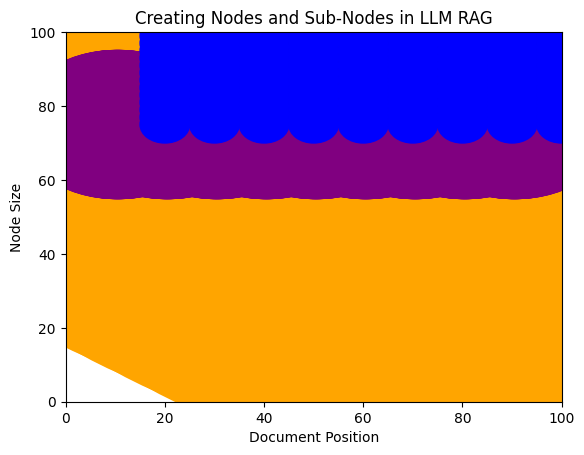

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Define node sizes
node_size = np.linspace(50, 100, 10)

# Create nodes
nodes = []
for i in range(10):
    node = plt.Circle((i * 10, np.mean(node_size)), node_size[i], color='orange')
    nodes.append(node)

# Add overlap nodes
overlap_nodes = []
for i in range(10):
    for j in range(10):
        if i > 0 and j > 0:
            overlap_node = plt.Circle((i * 10 + j * 0.1, np.mean(node_size)), 20, color='purple')
            overlap_nodes.append(overlap_node)

# Add sub-nodes
sub_nodes = []
for node in nodes:
    for i in range(int(node_size[0] * 0.8)):
        sub_node = plt.Circle((node.get_center()[0] + 20, node.get_center()[1] + i * 2), 5, color='blue')
        sub_nodes.append(sub_node)

# Create plot
fig, ax = plt.subplots()

# Add nodes and sub-nodes
for node in nodes:
    ax.add_artist(node)

for overlap_node in overlap_nodes:
    ax.add_artist(overlap_node)

for sub_node in sub_nodes:
    ax.add_artist(sub_node)

# Set limits and labels
ax.set_xlim(0, 100)
ax.set_ylim(0, max(node_size))
ax.set_xlabel('Document Position')
ax.set_ylabel('Node Size')

# Display plot
plt.title('Creating Nodes and Sub-Nodes in LLM RAG')
plt.show()
